In [2]:
%load_ext autoreload
%autoreload 2

# Report September

**Goal:** Super Resolution of images of turbolence

**data:** An image of a turbolence is the respesentation of the 2D velocity field 
$$\mathbf{u}_t(x,y) = [v_t^{\mathtt{x}}(x,y), v_t^\mathtt{y}(x,y)]$$
of a turbulent flow at the timestemp $t$, where $v_t^{\mathtt{k}}(x,y)$ is the velocity component with respect to the $k$-th axis, being $k = \{x,y\}$.

**simplification:** for now we consider only a single image, that is fixing the timestap $t$.  
Therefore we consider that the 2D velocity field $\mathbf{u}$ is a (differential) function of the spatial coordinates $\mathbf{x} = [x, y]$

$$\mathbf{u}(\mathbf{x}) = f(\mathbf{x})$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# some imports from my project library
from turboflow.dataloaders import load_turbo2D_simple_numpy
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

Let s load and plot our data, from the Turbo2D dataset [Heitz2007]

In [4]:
# ds=downsampling factor
Xlr, Ulr = load_turbo2D_simple_numpy(ds=4) # low resolution (64x64)
Xmr, Umr = load_turbo2D_simple_numpy(ds=2) # mid resolution (128x128)
Xhr, Uhr = load_turbo2D_simple_numpy(ds=1) # high (max) resolution (256x256)

L = int(Xlr.shape[0]**0.5)
M = int(Xmr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (128, 128, 2)
Y min, max: -2.371183 2.985797
after normalization, Y min, max: -0.7941541236728418 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0


`Xlr` and `ylr` are the low resolution (LR) meshgrid and 2D velocitity field, respectively.

`Xmr` and `ymr` are the mid resolution (LR) meshgrid and 2D velocitity field, respectively.

`Xhr` and `yhr` are the high resolution (HR) meshgrid and 2D velocitity field, respectively.

Low Resolution Field: 64 x 64


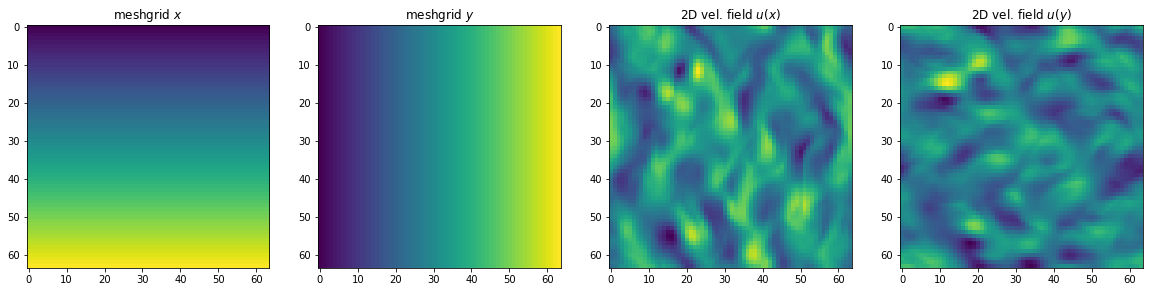

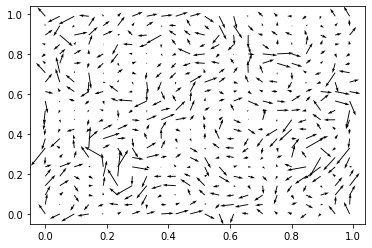

Mid Resolution Field 128 x 128


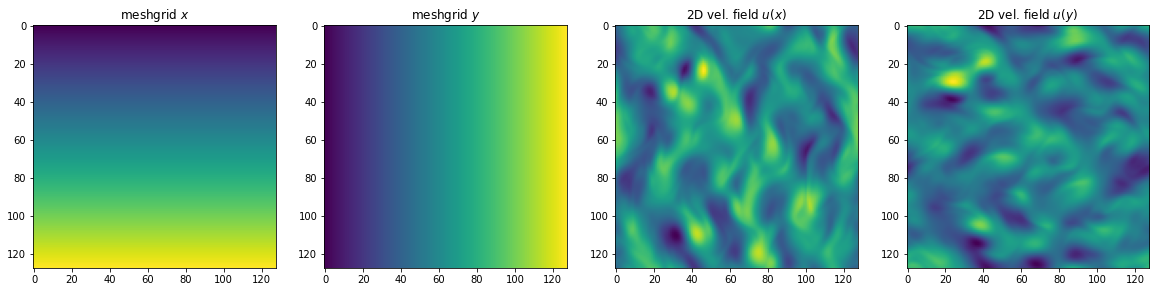

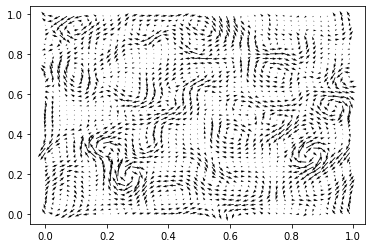

High Resolution Field 256 x 256


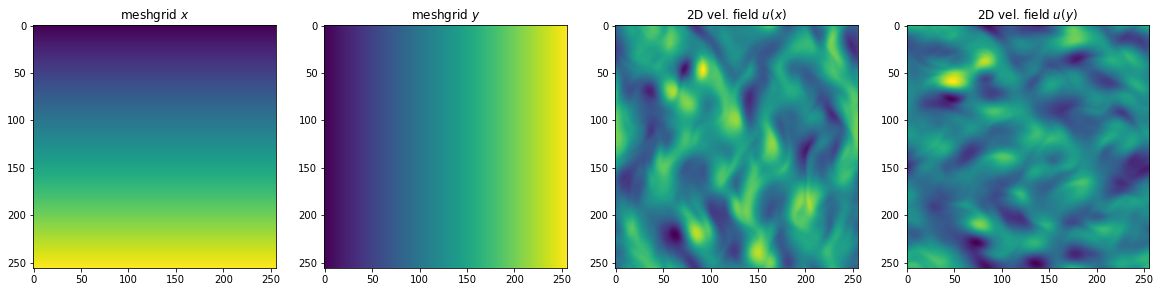

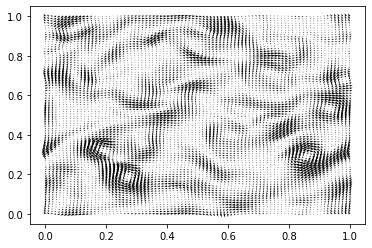

In [5]:
def plot_data(X,U):
    assert X.shape == U.shape
    assert X.shape[1] == 2
    D = int(X.shape[0]**0.5)
    
    X = X.reshape(D,D,2)
    xx = X[:,:,0]
    yy = X[:,:,1]
    U = U.reshape(D,D,2)
    ux = U[:,:,0]
    uy = U[:,:,1]

    fig, axarr = plt.subplots(1,4,figsize=(20,5))
    axarr[0].imshow(xx)
    axarr[0].set_title(r'meshgrid $x$')
    
    axarr[1].imshow(yy)
    axarr[1].set_title(r'meshgrid $y$')
    
    axarr[2].imshow(ux)
    axarr[2].set_title(r'2D vel. field $u(x)$')
    
    axarr[3].imshow(uy)
    axarr[3].set_title(r'2D vel. field $u(y)$')
    
    plt.show()
    
    ds = 3
    plt.quiver(xx[::ds,::ds], yy[::ds,::ds], 
               ux[::ds,::ds], uy[::ds,::ds])
    
    plt.show()
    return

print('Low Resolution Field: %d x %d' % (L, L))
plot_data(Xlr,Ulr)


print('Mid Resolution Field %d x %d' % (M, M))
plot_data(Xmr,Umr)

print('High Resolution Field %d x %d' % (H, H))
plot_data(Xhr,Uhr)

## (Single Image) Super Resolution

The goal is to increase the resolution of these images.
In fluido-dinamics termonology, we want to solve the *closure problem* of the given turbulence at a give timestemp $t$.

We put ourself in the following case:

- *HP1:* we dont have access to fully resolved data, that is, 
    - we cannot use the HR resolution image for training (for now).   
    - Nevertheless, we have access to the LR data on a LR meshgrid.
- *HP2:* at test time, we want to do off-grid evaluation, that is,
    - we want to evalutate the velocity field on a set of new off-grid query points
- *HP2.5:* we do interpolation: 
    - the query points are inside the coarse (=LR) grid.
- *HP3:* we consider a single timestamp (single image)
- *HP4:* we have some knowledge of the physical phenemon generating the data
    - incompressibility constraint
    - hyper-parameters of the Navier-Stokes equation

## Interpolation based upsampling (baseline 0)

one naive way to increase the resolution of an image is to interpolate the pixel.  
For instance, using a bilinear interpolator

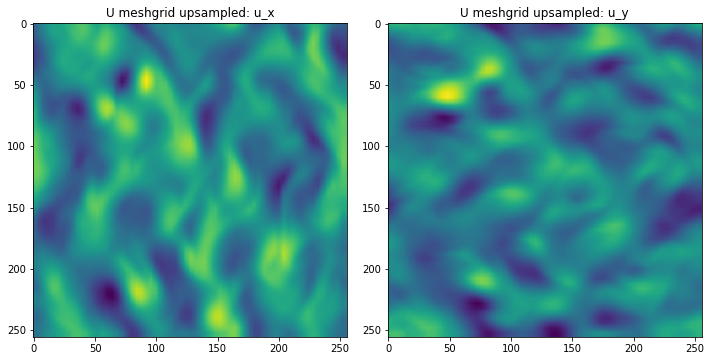

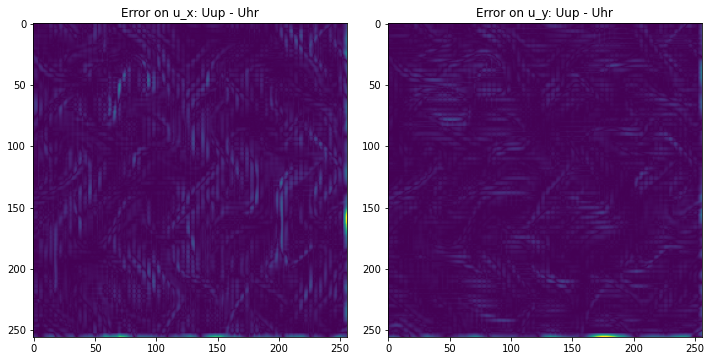

L2_Error(Uup-Hhr): 0.00013173826572771555
L1_Error(Uup-Hhr): 0.006981899176703026


In [6]:
U1up = dsp.interpolate2D_mesh01x01(Xlr.reshape(L,L,2), Ulr[:,0], scale=4)[:,:,None]
U2up = dsp.interpolate2D_mesh01x01(Xlr.reshape(L,L,2), Ulr[:,1], scale=4)[:,:,None]
Uup = np.concatenate([U1up, U2up], axis=-1)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('U meshgrid upsampled: u_x')
plt.imshow(Uup[:,:,0])
plt.subplot(122)
plt.title('U meshgrid upsampled: u_y')
plt.imshow(Uup[:,:,1])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Error on u_x: Uup - Uhr')
plt.imshow(np.abs(Uup[:,:,0] - Uhr.reshape(H,H,2)[:,:,0]))
plt.subplot(122)
plt.title('Error on u_y: Uup - Uhr')
plt.imshow(np.abs(Uup[:,:,1] - Uhr.reshape(H,H,2)[:,:,1]))
plt.tight_layout()
plt.show()

print('L2_Error(Uup-Hhr):', np.mean(np.abs(Uup - Uhr.reshape(H,H,2))**2))
print('L1_Error(Uup-Hhr):', np.mean(np.abs(Uup - Uhr.reshape(H,H,2))))

The images look nice, and the interpolation is quite low in average.  
However, do they respect the instrinsic physical properties of the turbulent flow?  

One of the first physical property that must be respected is the **incrompressibily of the flow**, that is, the velocity field must respect the constraint: 

$$\nabla_\mathbf{x} \mathbf{u} = 0$$

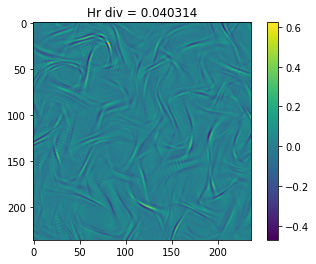

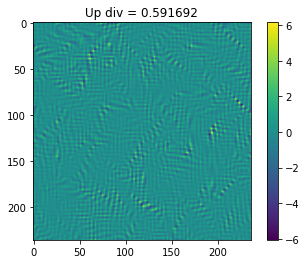

In [8]:
def my_div(U, X):
    assert U.shape == X.shape
    assert U.shape[1] == 2
    D = U.shape[1]
    N = U.shape[0]
    L = int(np.sqrt(N))
    
    Ureshaped = U.T.reshape(2,L,L)
    Xreshaped = X.T.reshape(2,L,L)
    points = [Xreshaped[0,:,0], Xreshaped[1,0,:]]
    sp = [np.diff(p)[0] for p in points]
    D = phy.divergence(Ureshaped, sp, indexing='ij')    
    return D

Dhr = my_div(Uhr, Xhr)

b = 10 # to remove artifacts of gradient estimation at the boundaries

plt.title('Hr div = %f' % np.mean(np.abs(Dhr[b:-b,b:-b])))
plt.imshow(Dhr[b:-b,b:-b])
plt.colorbar()
plt.show()

Dup = my_div(Uup.reshape(H*H,2), Xhr)
plt.title('Up div = %f' % np.mean(np.abs(Dup[b:-b,b:-b])))
plt.imshow(Dup[b:-b,b:-b])
plt.colorbar()
plt.show()

From these images, we can see that the constrain is not respected when upsampling with a standard bilinear interporation.

Another way to assess the physical consistency of the upsampling is to check the **energy spectrum** of the velocity field.

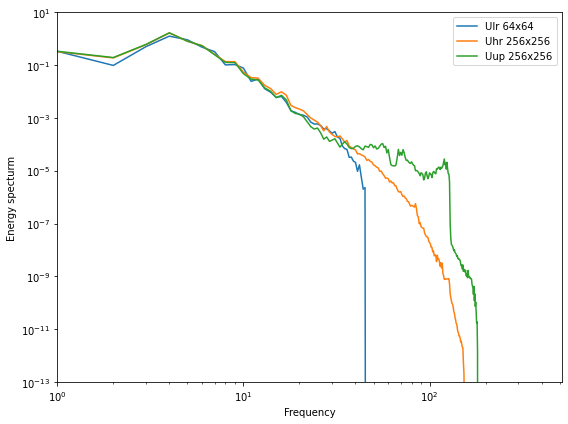

In [9]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Uup.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uup.reshape(H,H,2)[:,:,0]), label='Uup 256x256')
axs.set_ylim(10**(-13), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

According to the Kolmogorov model (K41), the energy specturm of the 2D velocity field of the 2D turbulence flow should follow a particoular behaviour, know as the *-5/3 law*.

That is, at high Reynold number (indicator of the turbulence of a flow), the slope of the energy spectrum (within the so called *inertial subrange*) has slope of $-5/3$.  

**disclaimer:** up to now, we dont know the inertial subrange for the Turbo2D data. We need to ask it the authors of [Heitz2007] (who is a colleague of Thomas).

More formally, the inertial subrange the energy spectrum $E(k)$ of the turbulence must be of the form:

$$
E(k) = C \varepsilon_0^{2/3} k^{-5/3} \quad (l^{-1} \ll k \ll \eta^{-1})
$$
where:
- $C$ is a constant of the flow,
- $\varepsilon_0$ is the rate of energy dissipation,
- $\eta$ is the 'Kolmogorov's length', corresponding the minimum size after which we pass from self-similar turbulence to diffusion regime)
- $l$ is the 'energy-constating scale', correposding to the size of the biggest vortices.

We can see that the interepolation upsampling is adding information as
- it is increasing the bandwidth of the spectrum (from the blue line, to the green one);
- **and** increase the energy content at higher frequency.

However this information is not consistent with the physics, since, it should approximate the orange line.  
In other words, everything which is above the orange line is artificial noise / artifacts.

## Deep Learning based upsampling (baseline 1)

We can levarange on the recent Deep Learning studies to build a model which can learn the intrisict physics 
from the data.

In particular, we can use the so called coordinate-based MLP model to estimate the function $f : \mathbf{x} \mapsto \mathbf{u}$.  

The state-of-the-art **coord-MLP**  [[Tancik2020](https://arxiv.org/pdf/2006.10739.pdf)] uses a simple MLP model whose input are first projected into **Random Fourier Features** (RFF).  
This model is here denoted as RFFNet.  

- A coord-based MLP learns to encode the training data as is overfitting them by construction.  
- It can be show that this is equivalent to do **kernel regression** of the training data.  
    - The associated kernel learn by the MLP is know as Neural Tangent Kernel (NTK). [[Jacot2018](https://arxiv.org/pdf/1806.07572.pdf%E5%85%B3%E5%BF%83CNN%E7%9A%84%E8%AF%9D%E5%AF%B9%E4%BA%8Eresidual)]
    - The RFF is a trick (wellknow from Kernel regression) used to speed up convergence and accuracy.

At train model learn the map $f_{LR} : \mathbf{x}_{LR} \mapsto \mathbf{u}_{LR}$.
At test time the model process off-grid coordinates within the training meshgrid, that is 
    $$f(\mathbf{x}_{OF})$$
 where $\mathbf{x}_{OF}$ are off-grid points within the coase grid used for training.

In [10]:
import torch
from turboflow.models.rff import RFFNet
from turboflow.dataloaders import Turbo2D_simple
from torch.utils.data import Dataset, DataLoader

# set up cuda 
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

rffnet = RFFNet('RFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
rffnet.to(device)
rffnet.fit(trainloader, epochs=2000) # we are not afraid to overfit the data, this is coord-based MLP!

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: 0.001646
Epoch: 200, Loss: 0.000036
Epoch: 300, Loss: 0.000005
Epoch: 400, Loss: 0.000002
Epoch: 500, Loss: 0.000001
Epoch: 600, Loss: 0.000001
Epoch: 700, Loss: 0.000002
Epoch: 800, Loss: 0.000000
Epoch: 900, Loss: 0.000001
Epoch: 1000, Loss: 0.000000
Epoch: 1100, Loss: 0.000001
Epoch: 1200, Loss: 0.000004
Epoch: 1300, Loss: 0.000001
Epoch: 1400, Loss: 0.000000
Epoch: 1500, Loss: 0.000000
Epoch: 1600, Loss: 0.000000
Epoch: 1700, Loss: 0.000000
Epoch: 1800, Loss: 0.000000
Epoch: 1900, Loss: 0.000000
Epoch: 2000, Loss: 0.000000
Done with Training
Final error: 1.126371444115648e-06


At test time we can run the model on a set of new off-grid point, for instance a meshgrid of HR resolution

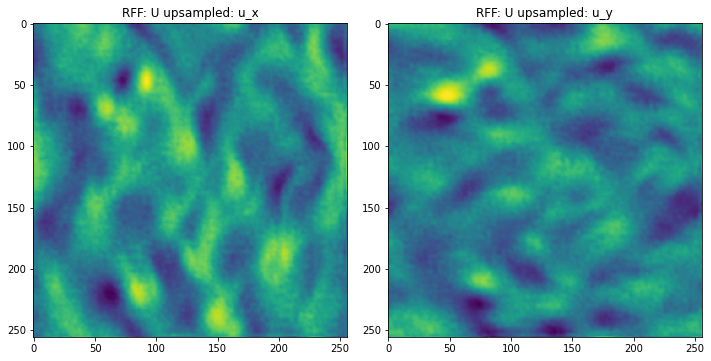

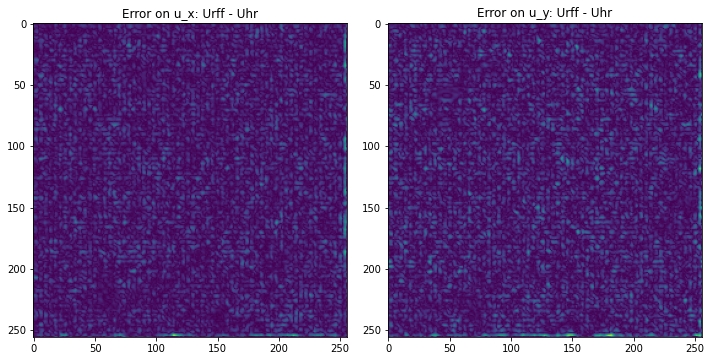

L2_Error(Uup-Hhr): 0.001001149545354108
L1_Error(Uup-Hhr): 0.02374025097782955


In [11]:
# TEST!
x = torch.from_numpy(Xhr).float().contiguous().to(device)
rffnet.eval().to(device)
u_hat = rffnet(x)
Urff = u_hat.cpu().detach().numpy().squeeze().reshape(H,H,2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Urff[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Urff[:,:,1])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Error on u_x: Urff - Uhr')
plt.imshow(np.abs(Urff[:,:,0] - Uhr.reshape(H,H,2)[:,:,0]))
plt.subplot(122)
plt.title('Error on u_y: Urff - Uhr')
plt.imshow(np.abs(Urff[:,:,1] - Uhr.reshape(H,H,2)[:,:,1]))
plt.tight_layout()
plt.show()

print('L2_Error(Uup-Hhr):', np.mean(np.abs(Urff - Uhr.reshape(H,H,2))**2))
print('L1_Error(Uup-Hhr):', np.mean(np.abs(Urff - Uhr.reshape(H,H,2))))

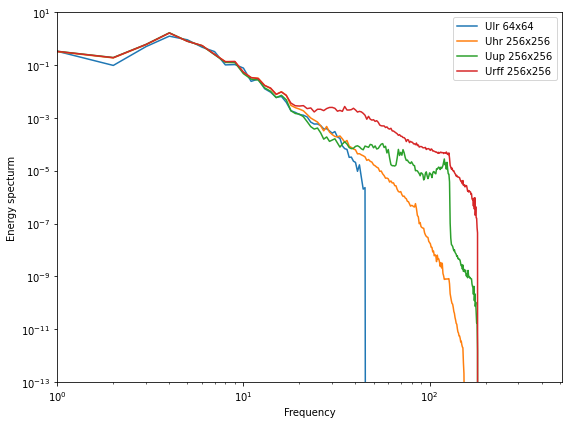

In [12]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Uup.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uup.reshape(H,H,2)[:,:,0]), label='Uup 256x256')
axs.loglog(np.arange(len(phy.powerspec(Urff.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Urff.reshape(H,H,2)[:,:,0]), label='Urff 256x256')
axs.set_ylim(10**(-13), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

We can see that a coord-based MLP is able to upsample the image and allows for simple and fast off-grid evaluation at test time.  

However the images are not better than a simple interpolation and the physical constraint $\nabla \mathbf{u} = 0$  it is not respected, as we can see from the following results.

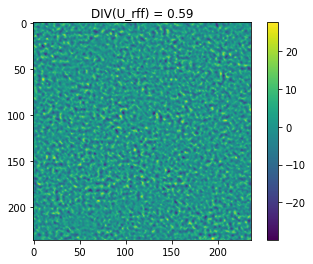

In [13]:
Drff = my_div(Urff.reshape(H*H,2), Xhr)
plt.imshow(Drff[b:-b,b:-b])
plt.colorbar()
plt.title('DIV(U_rff) = %1.2f' % np.mean(np.abs(Dup[b:-b,b:-b])))
plt.show()

Nevertheless, this approach is very practical at test time.

In fact, we can easily run the model on any input meshgrid, which constant computational time.

(65536, 2)


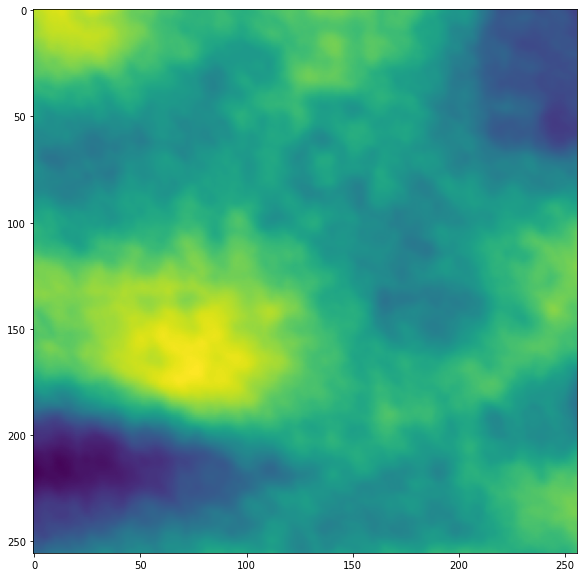

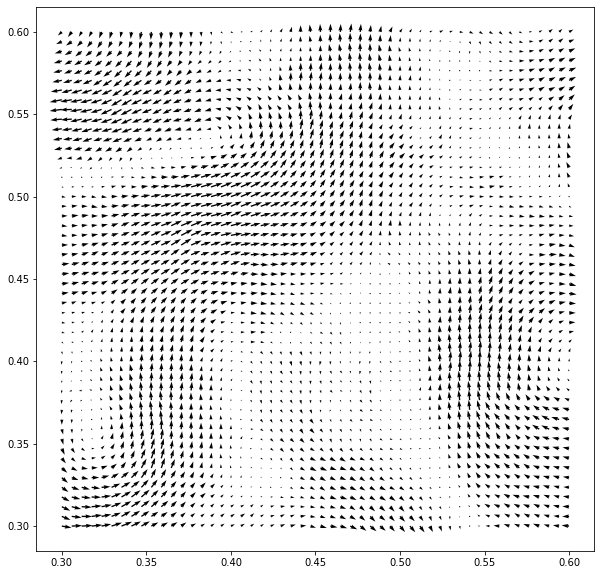

In [19]:
# Let s zoom in it!
ngrid = 256
coords = np.linspace(0.3, 0.6, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

rffnet.eval().to(device)
pred = rffnet(x)
pred = pred.cpu().detach().numpy().squeeze().reshape(ngrid,ngrid,2)

plt.figure(figsize=(10,10))
plt.imshow(pred[:,:,0])
plt.show()

s = 5
plt.figure(figsize=(10,10))
plt.quiver(coords.reshape(ngrid,ngrid,2)[::s,::s,0],
           coords.reshape(ngrid,ngrid,2)[::s,::s,1],
           pred[::s,::s,0],pred[::s,::s,1])

Moreover, we can leverage the property of DNN models for:
- use ad-hoc loss function (e.g. adding physics-based regularization terms) [[Hendriks2021](https://arxiv.org/pdf/2002.01600.pdf)]
- use ad-hoc cost function (e.g. based of the ROC/AUC of the energy spectrum)
- change network topology and add custom layers [[Li2021](https://arxiv.org/pdf/2010.08895.pdf)]
- add side information, such as context computed from a CNN [[Jiang2020](https://arxiv.org/pdf/2005.01463.pdf)]
- use off-grid data during traning time

## Physics-informed Deep Learning based upsampling (baseline 2)

A way to impose some physics-based constraint in the Neural Network is to follow the works on **Physics-informed NN (PINN)** [[Raissi2018](https://www.sciencedirect.com/science/article/pii/S0021999118307125)].  
PINN are used to solve PDE and in general the model are simple extension of coord-based MLP, where the loss function encode the PDE.

For instance we can add the $\nabla \mathbf{u} = 0$ to the MSE loss function, that is:

$$
\mathcal{L}_\theta = \| \hat{\mathbf{u}} - \mathbf{u} \|_2^2 + \lambda_\text{phy} \| \nabla \hat{\mathbf{u}} \|_2^2
$$

where $\hat{\mathbf{u}} = \mathtt{MLP}(\mathbf{x})$ and $\mathbf{u}$ is the ground truth.  
Notice that $\mathbf{u}$ is the low resolution 2D vector field. The HR image/field is never used.

In [18]:
from turboflow.models.phyrff_soft import PiRFFNet


# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2
nout = 2
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

pirffntet = PiRFFNet('PIRFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
pirffntet.to(device)
pirffntet.fit(trainloader, epochs=3000)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: (0.018235 + 134.209244) = 0.031656
Epoch: 200, Loss: (0.001829 + 75.204338) = 0.009350
Epoch: 300, Loss: (0.000853 + 61.656319) = 0.007019
Epoch: 400, Loss: (0.000602 + 55.471745) = 0.006149
Epoch: 500, Loss: (0.000475 + 51.334064) = 0.005608
Epoch: 600, Loss: (0.000398 + 45.709621) = 0.004969
Epoch: 700, Loss: (0.000321 + 42.007511) = 0.004522
Epoch: 800, Loss: (0.000285 + 40.102219) = 0.004295
Epoch: 900, Loss: (0.000270 + 37.943142) = 0.004064
Epoch: 1000, Loss: (0.000240 + 35.426224) = 0.003783
Epoch: 1100, Loss: (0.000222 + 33.728931) = 0.003594
Epoch: 1200, Loss: (0.000198 + 33.276600) = 0.003526
Epoch: 1300, Loss: (0.000188 + 30.422405) = 0.003230
Epoch: 1400, Loss: (0.000178 + 29.426199) = 0.003121
Epoch: 1500, Loss: (0.000172 + 28.001247) = 0.002972
Epoch: 1600, Loss: (0.000162 + 26.8173

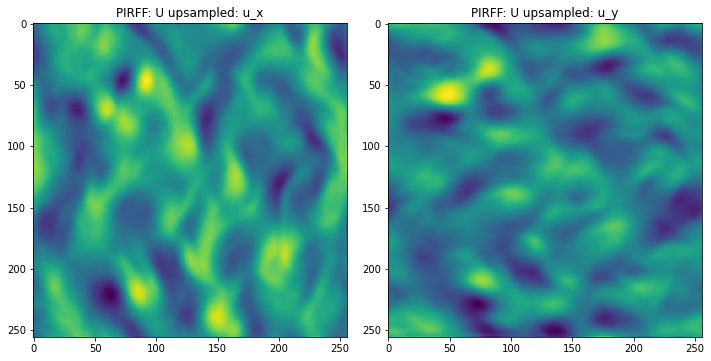

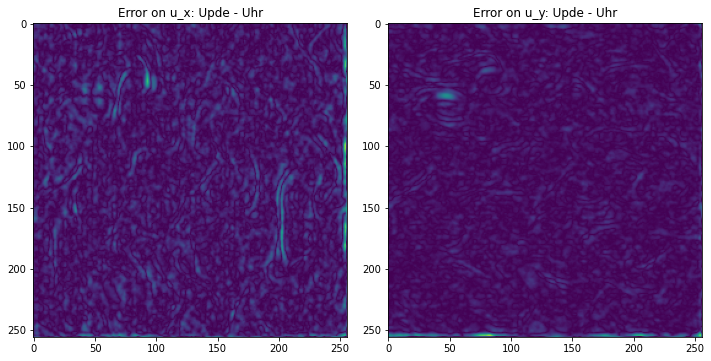

L2_Error(Uup-Hhr): 0.0001535702815225928
L1_Error(Uup-Hhr): 0.008758730115804613


In [20]:
# TEST!
x = torch.from_numpy(Xhr).float().contiguous().to(device)

pirffntet.eval().to(device)
pred = pirffntet(x)
Upde = pred.cpu().detach().numpy().squeeze().reshape(H,H,2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('PIRFF: U upsampled: u_x')
plt.imshow(Upde[:,:,0])
plt.subplot(122)
plt.title('PIRFF: U upsampled: u_y')
plt.imshow(Upde[:,:,1])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Error on u_x: Upde - Uhr')
plt.imshow(np.abs(Upde[:,:,0] - Uhr.reshape(H,H,2)[:,:,0]))
plt.subplot(122)
plt.title('Error on u_y: Upde - Uhr')
plt.imshow(np.abs(Upde[:,:,1] - Uhr.reshape(H,H,2)[:,:,1]))
plt.tight_layout()
plt.show()

print('L2_Error(Uup-Hhr):', np.mean(np.abs(Upde - Uhr.reshape(H,H,2))**2))
print('L1_Error(Uup-Hhr):', np.mean(np.abs(Upde - Uhr.reshape(H,H,2))))

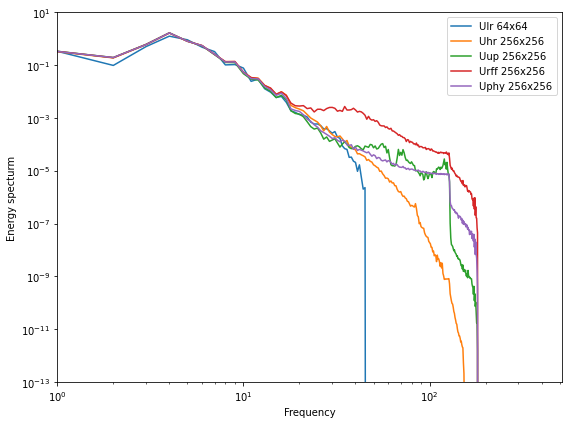

In [21]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Uup.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uup.reshape(H,H,2)[:,:,0]), label='Uup 256x256')
axs.loglog(np.arange(len(phy.powerspec(Urff.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Urff.reshape(H,H,2)[:,:,0]), label='Urff 256x256')
axs.loglog(np.arange(len(phy.powerspec(Upde.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Upde.reshape(H,H,2)[:,:,0]), label='Uphy 256x256')
axs.set_ylim(10**(-13), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

From the above Figure, we can see that effect of imposing the physics-based regularization term: the Energy-spectrum (in violet) is closer to the groundtruth one (in orange), meaning that more meaning that this network is adding less artifact than the un-regularized one.

In term of divergence, however...

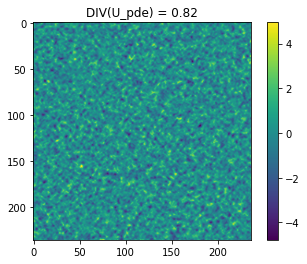

In [24]:
Dpde = my_div(Upde.reshape(H*H,2), Xhr)

plt.imshow(Dpde[b:-b,b:-b])
plt.colorbar()
plt.title('DIV(U_pde) = %1.2f' % np.mean(np.abs(Dpde[b:-b,b:-b])))
plt.show()

This because we intruduced a **soft-constraint**, meaning that the network $\nabla \mathbf{u} = 0$ is minimized, but not satisfied at the output.

However, let's zoom, to appreaciate the beauty of the prediction

(65536, 2)


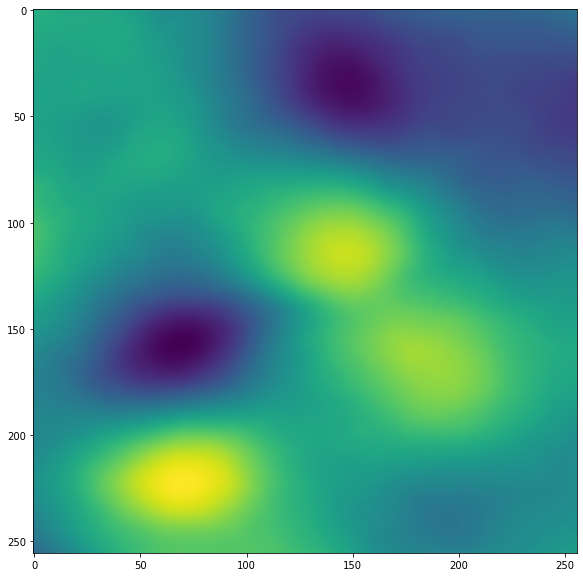

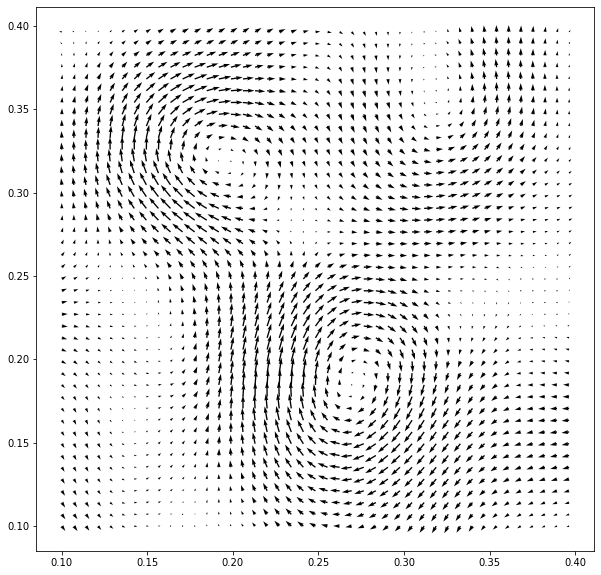

In [34]:
# Let s zoom in it!
ngrid = 256
coords = np.linspace(0.1, 0.4, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

pirffntet.eval().to(device)
pred = pirffntet(x)
pred = pred.cpu().detach().numpy().squeeze().reshape(ngrid,ngrid,2)

plt.figure(figsize=(10,10))
plt.imshow(pred[:,:,0])
plt.show()

s = 6
plt.figure(figsize=(10,10))
plt.quiver(coords.reshape(ngrid,ngrid,2)[::s,::s,0],
           coords.reshape(ngrid,ngrid,2)[::s,::s,1],
           pred[::s,::s,0],pred[::s,::s,1])

## HOW TO IMPROVE??

### Hard Constraint instead of Soft ones
Imposing $\nabla \mathbf{u} = 0$ in the loss function is called in the literature imposing *soft constraint*.  

The model is regularized by the minimizing such a penalty, but the constraint is not necesseraly satisfied at the output.

In the literature we can find two way to incorporante $\nabla \mathbf{u} = 0$ as **hard constraint**:

1. use the coord-MLP to predict the *potential* $\Phi(\mathbf{x})$ and add the following layer to the network

$$ \hat{\mathbf{u}} = 
\begin{bmatrix}
 \frac{\partial}{\partial {x_2}} \\ 
-\frac{\partial}{\partial {x_1}}
\end{bmatrix}
\Phi(\mathbf{x})  = 
\begin{bmatrix}
 \frac{\partial}{\partial {x_2}} \\ 
-\frac{\partial}{\partial {x_1}}
\end{bmatrix}
\mathtt{MLP}(\mathbf{x})
$$
2. Under the hood of Kernel interpolation / Radial Basis Function (RBF) interpolation, use Divergence-free Matrix-valued Kernel [[Macedo2010](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjL0P7hoZLzAhVDcBQKHaLOB10QFnoECAMQAQ&url=https%3A%2F%2Fnoticias.impa.br%2Fauth%3Fdoc%3D1633&usg=AOvVaw2edSs_VuOmPhOfDTWzg48Y)] and [[McNally2011](https://arxiv.org/pdf/1102.4852.pdf)].
  Here the matrix-valued interpolation kernel is build as:

$$K(\mathbf{x}) = (\nabla\nabla^T - \nabla^2 \mathbf{I})\phi(\mathbf{x})$$

where $\phi(x)$ is the RBF is a scalar valued radial basis function and $\mathbf{I}$ is the identity matrix.

**disclaimer** I been working on this second approach on the last month, but it was not working well. I suspect:
- numerical issues and computational instability in computing the 2-nd order derivates with autograd as well as the 3rd order ones needed by the backpropagation algorithm.  
  Possible solutions to this are:
  - implement analytically the 2nd derivatives of the MLP which should not be so hard
  - combino RBF/GaussianProcess and neural network in some works in Deep Kernel Learning [[Wilson2016](https://proceedings.mlr.press/v51/wilson16.html),[Huang2015](https://www.aaai.org/ocs/index.php/IJCAI/IJCAI15/paper/viewPaper/11045)] and RBF-network [[Broomhead1988](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1988-Broomhead-CS.pdf)]


Here follows the implementation of the method in [1.]

In [70]:
from turboflow.models.phyrff_hard import DivFreeRFFNet


# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2
nout = 1
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]
lam_pde = 100

dfrffnetet = DivFreeRFFNet('DFRFFNet', mlp_layers, fft_nfeat, fft_scale, lam_pde=lam_pde)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# # TRAIN!
dfrffnetet.to(device)
dfrffnetet.fit(trainloader, epochs=3000)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: (rec: [0.044037] + 100.000000 * div-free: [0.000000]) = 0.044050
Epoch: 200, Loss: (rec: [0.033274] + 100.000000 * div-free: [0.000000]) = 0.033291
Epoch: 300, Loss: (rec: [0.021458] + 100.000000 * div-free: [0.000000]) = 0.021486
Epoch: 400, Loss: (rec: [0.008153] + 100.000000 * div-free: [0.000001]) = 0.008216
Epoch: 500, Loss: (rec: [0.002549] + 100.000000 * div-free: [0.000001]) = 0.002653
Epoch: 600, Loss: (rec: [0.000837] + 100.000000 * div-free: [0.000001]) = 0.000961
Epoch: 700, Loss: (rec: [0.000264] + 100.000000 * div-free: [0.000001]) = 0.000400
Epoch: 800, Loss: (rec: [0.000084] + 100.000000 * div-free: [0.000001]) = 0.000225
Epoch: 900, Loss: (rec: [0.000033] + 100.000000 * div-free: [0.000001]) = 0.000177
Epoch: 1000, Loss: (rec: [0.000013] + 100.000000 * div-free: [0.000001]) = 0.0

It can be noticed that during training the error on div-free constraint is violated, as it increasing.  
However the reconstruction error fastly decrease.

In [77]:
# let s check the divergence-free constrain
x = torch.randn((1000,2)).to(device)
dfrffnetet.eval().to(device)
y_hat = dfrffnetet(x)

u, v = torch.split(y_hat,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
div_u_xy = du_xy[...,0] + dv_xy[...,1]
print(torch.mean(torch.abs(div_u_xy)))

tensor(1.5048e-05, device='cuda:0', grad_fn=<MeanBackward0>)


The error on the validation set is small and the divergece constraint seems respected, however on the test set:

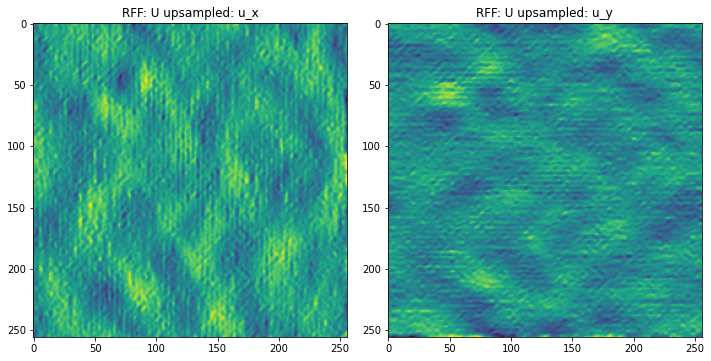

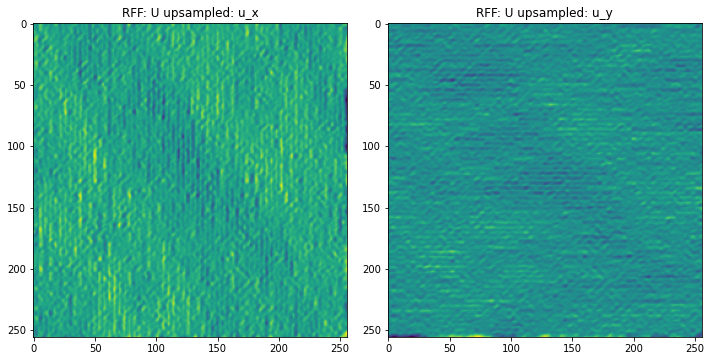

In [78]:
# TEST!
x = torch.from_numpy(Xhr).float().contiguous().to(device)

dfrffnetet.eval().to(device)
pred = dfrffnetet(x)
Udfphy = pred.cpu().detach().numpy().squeeze().reshape(H,H,2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Udfphy[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Udfphy[:,:,1])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Udfphy[:,:,0] - Uhr.reshape(H,H,2)[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Udfphy[:,:,1] - Uhr.reshape(H,H,2)[:,:,1])
plt.tight_layout()
plt.show()

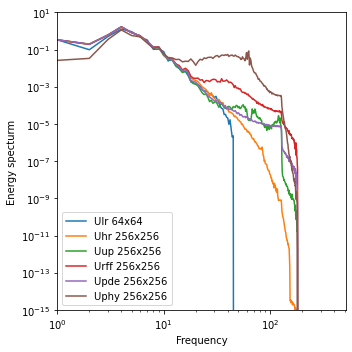

In [79]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Uup.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uup.reshape(H,H,2)[:,:,0]), label='Uup 256x256')
axs.loglog(np.arange(len(phy.powerspec(Urff.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Urff.reshape(H,H,2)[:,:,0]), label='Urff 256x256')
axs.loglog(np.arange(len(phy.powerspec(Upde.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Upde.reshape(H,H,2)[:,:,0]), label='Upde 256x256')
axs.loglog(np.arange(len(phy.powerspec(Udfphy.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Udfphy.reshape(H,H,2)[:,:,0]), label='Uphy 256x256')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

While maintaning the $\nabla \mathbf{u}$ very small, the model add lot of artifacts

(65536, 2)


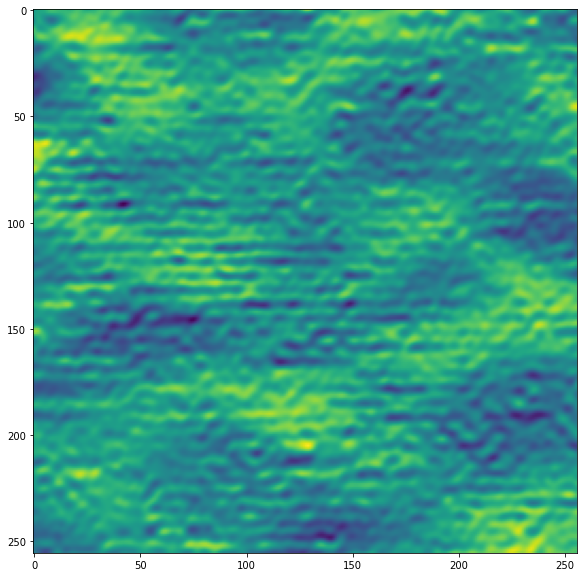

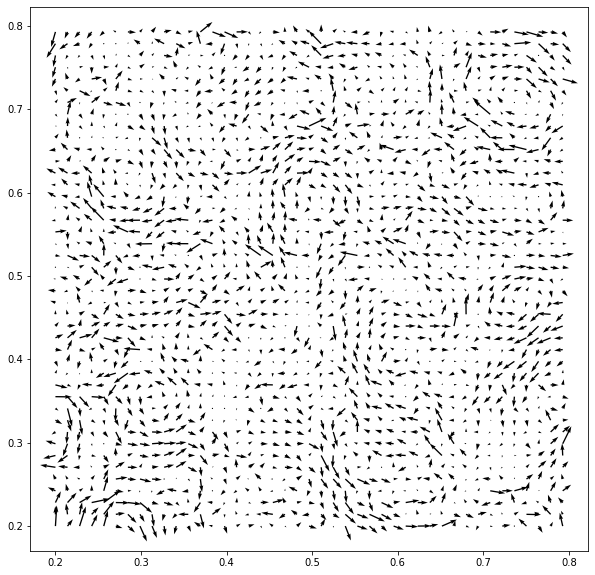

In [88]:
# Let s zoom in it!
ngrid = 256
coords = np.linspace(0.2, 0.8, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

dfrffnetet.eval().to(device)
pred = dfrffnetet(x)
Udiv = pred.cpu().detach().numpy().squeeze().reshape(ngrid,ngrid,2)

plt.figure(figsize=(10,10))
plt.imshow(Udiv[:,:,0])
plt.show()

s = 6
plt.figure(figsize=(10,10))
plt.quiver(coords.reshape(ngrid,ngrid,2)[::s,::s,0],
           coords.reshape(ngrid,ngrid,2)[::s,::s,1],
           Udiv[::s,::s,0],Udiv[::s,::s,1])

It looks that the constraint is applied 'too much', creating high-frequency div-free texture

### Off-grid regularization based on Structure Function (Self-similarity Functions)
So far at train time we used only the coordinates and the field at low resolution. While the high-resolution data are not accessible, some physical properties of the data can be used and tested on high-resolution coordinates. For instance, during training time, one can see the Energy spectrum of some random highly sampled patches and just evalutate how distant such curve is from the K41 model.  
However building a loss on the K41 model may be not trivial. A solution came from the so-called Structure functions, that are local statistics of the vector field, for which well studied model are available (coming from the Kolmogorov theory).

Structure function $S^p(d)$ are $n$-th order statistics of the velocity field function of the spatial increment $d$:
$$
S^p(d) = < ((\mathbf{u}(\mathbf{x} + d\mathbf{n}) - \mathbf{u}(\mathbf{x})) \cdot \mathbf{n})^p >
$$
where $p$ is the order of the statistics (typically 2 or 3) and $<\cdot>$ is the average over point in a given domain $| \Omega |$.

For a turbulent flow, the turbulent velocity field $\mathbf{u}$ must follow the following low
$$
S^2(d) \sim \beta d^2
$$
for $d \in [0, \eta]$, where $\eta$ is defined by the problem.


In [89]:
nx, ny = Uhr.reshape(H,H,2)[:,:,0].shape

U2h = np.concatenate([Uhr.reshape(H,H,2)]*2, axis=1)
print(U2h.shape)
U2v = np.concatenate([Uhr.reshape(H,H,2)]*2, axis=0)
print(U2v.shape)
U2d = np.concatenate([U2h, U2h], axis=0)
print(U2d.shape)

increments = np.arange(H)
sfun = np.zeros((H,3))

Uhr_sq = Uhr.reshape(H,H,2)

for d in increments:
    
    # horizontal axis 
    diff_h = (U2h[:,d:H+d,:] - Uhr_sq)**2
    diff_h = diff_h[1]
    
    # vertical axis 
    diff_v = (U2v[d:H+d,:,:] - Uhr_sq)**2
    diff_v = diff_v[0]
    
    # diagonal axis
    diff_d = (U2d[d:H+d,d:H+d,:] - Uhr_sq)**2
    diff_d = (diff_d[0]+diff_d[1])/2
    
    sfun[d,0] = diff_h.mean()
    sfun[d,1] = diff_v.mean()
    sfun[d,2] = diff_d.mean()
    

(256, 512, 2)
(512, 256, 2)
(512, 512, 2)


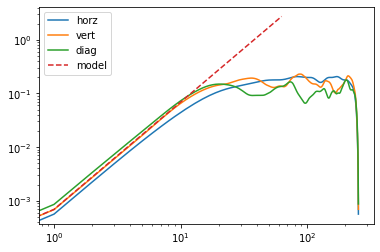

In [90]:
c = 0.25
plt.loglog(sfun[:,0], label='horz')
plt.loglog(sfun[:,1], label='vert')
plt.loglog(sfun[:,2], label='diag')
plt.loglog(np.arange(nx//4), c*0.00275*np.arange(nx//4)**2, '--', label='model')
plt.legend()
plt.show()

### Structure-function regularization

At training time, it is possible to evalute the structure function on the prediction of the MLP on off-grid data.

Let be the following quantities:

$\mathbf{x}_{LR} \in \mathcal{D}_{LR} = [0:\Delta_x:1]\times[0:\Delta_y:1] \subset \mathbb{Q}^2$ the low resolution input grid

$\mathbf{x}_{OF} \in \mathcal{D}_{OF} = [0,1]\times[0,1] \subset \mathbb{R}^2$ the off-grid data point

At training time, the network is optimize with the following loss function

$$
\mathcal{L}_\theta = \sum_i \| u_{LR}[i] - \mathtt{MLP}(\mathbf{x}_{LR}[i]) \|^2 
                   + \sum_i \| S^2(d, \mathtt{MLP}(\mathbf{x}_{OF}[i])) - \beta d^2 \|^2 
$$


**Work in progess**